# Are We Talking to Robots? A Data Science Investigation Into Reddit Bots

---

## The Dead Internet Theory Meets Machine Learning

There's this creepy theory floating around called the **Dead Internet Theory**. The idea? That most of the "people" you interact with online... aren't actually people. They're bots. AI. Automated accounts farming engagement, reposting content, and summarizing news articles like they're getting paid per click.

Paranoid fantasy? Maybe. But what if we could actually *detect* these bots using data science?

That's exactly what we're doing today.

**Our Dataset:** 500 Reddit comments scraped from popular subreddits, each labeled as either human or bot, with behavioral metadata like:
- How old is the account?
- How fast did they reply?
- What's their karma?
- Do they drop links in comments?
- What's the sentiment and writing style?

**Our Mission:** Build a machine learning model that can sniff out bots from humans.

**The Stakes:** Your sanity every time you scroll Reddit.

Let's get into it.

---

# PART 1: Setup & First Look

Time to load our tools and see what we're working with.

In [8]:
# === THE TOOLBOX ===
# Data wrangling
import os
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tests
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_score, recall_score, f1_score)

# Silence the noise
import warnings
warnings.filterwarnings('ignore')

# Make plots pretty
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('All libraries loaded successfully!')
print('Ready to hunt some bots.')

All libraries loaded successfully!
Ready to hunt some bots.


**What just happened:** We imported everything we need - pandas for data, matplotlib/seaborn for pretty charts, scipy for statistics, and a whole arsenal of sklearn models for the classification showdown later.

**The takeaway:** Our toolkit is ready. Time to load the data and see what we're dealing with.

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nudratabbas/the-dead-internet-theory-reddit-bot-vs-human")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'the-dead-internet-theory-reddit-bot-vs-human' dataset.
Path to dataset files: /kaggle/input/the-dead-internet-theory-reddit-bot-vs-human


In [10]:
print(os.listdir(path))

['.nfs000000001e54ad0c00000116', 'reddit_dead_internet_analysis_2026.csv']


In [11]:
df = pd.read_csv(os.path.join(path,'reddit_dead_internet_analysis_2026.csv'))

print(f'Dataset Shape: {df.shape[0]} comments, {df.shape[1]} features')
print('\n' + '='*50)
print('COLUMNS:')
print('='*50)
for col in df.columns:
    print(f'  - {col}')

Dataset Shape: 500 comments, 11 features

COLUMNS:
  - comment_id
  - subreddit
  - account_age_days
  - user_karma
  - reply_delay_seconds
  - sentiment_score
  - avg_word_length
  - contains_links
  - is_bot_flag
  - bot_type_label
  - bot_probability


**What just happened:** We loaded 500 Reddit comments with 11 columns of data.

**The takeaway:** Each row is a comment. Each column tells us something about either the user who posted it or the comment itself. That's a decent amount of behavioral data to work with.

In [12]:
# === FIRST LOOK ===
print('FIRST 5 ROWS:')
print('='*80)
df.head()

FIRST 5 ROWS:


,comment_id,subreddit,account_age_days,user_karma,reply_delay_seconds,sentiment_score,avg_word_length,contains_links,is_bot_flag,bot_type_label,bot_probability
0,t1_3148938807,funny,2264,34192,1854,-0.60,4.62,False,False,None (Human),0.093
1,t1_2516748923,gaming,1654,2812,1033,0.15,5.84,False,False,None (Human),0.117
2,t1_833922318,politics,2442,37109,2703,0.35,5.73,False,False,None (Human),0.115
3,t1_3987809057,funny,168,32997,2811,-0.74,4.58,False,False,None (Human),0.094
4,t1_3931039688,gaming,801,25088,1721,-0.96,5.78,False,False,None (Human),0.116


**What just happened:** A quick peek at the first 5 rows.

**The takeaway:** We can see comment IDs, subreddits (funny, gaming, politics...), account ages, karma scores, reply times, and most importantly - the `is_bot_flag` column which is our target variable. That's what we're trying to predict.

In [13]:
# === DATA TYPES & MEMORY ===
print('DATA INFO:')
print('='*50)
df.info()

DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   comment_id           500 non-null    object 
 1   subreddit            500 non-null    object 
 2   account_age_days     500 non-null    int64  
 3   user_karma           500 non-null    int64  
 4   reply_delay_seconds  500 non-null    int64  
 5   sentiment_score      500 non-null    float64
 6   avg_word_length      500 non-null    float64
 7   contains_links       500 non-null    bool   
 8   is_bot_flag          500 non-null    bool   
 9   bot_type_label       500 non-null    object 
 10  bot_probability      500 non-null    float64
dtypes: bool(2), float64(3), int64(3), object(3)
memory usage: 36.3+ KB


**What just happened:** We checked the data types for each column.

**The takeaway:** Mix of integers, floats, objects (strings), and booleans. The `is_bot_flag` is already a boolean - perfect for binary classification. No missing values detected at first glance. This data looks surprisingly clean.

---

# PART 2: Exploratory Data Analysis (EDA)

Alright, let's really dig into this data. What makes a bot a bot? Are there obvious patterns? Let's find out.

TARGET DISTRIBUTION:
Humans (False): 282 (56.4%)
Bots (True):    218 (43.6%)


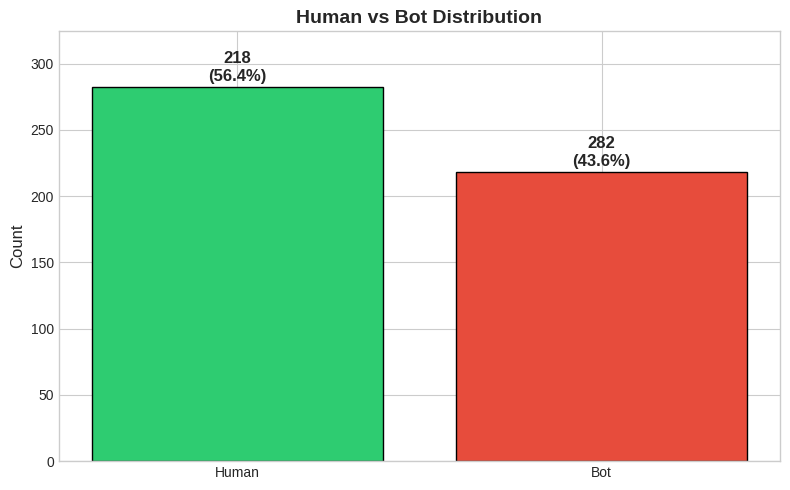

In [14]:
# === TARGET VARIABLE: BOT vs HUMAN ===
print('TARGET DISTRIBUTION:')
print('='*50)
target_counts = df['is_bot_flag'].value_counts()
target_pct = df['is_bot_flag'].value_counts(normalize=True) * 100

print(f'Humans (False): {target_counts[False]} ({target_pct[False]:.1f}%)')
print(f'Bots (True):    {target_counts[True]} ({target_pct[True]:.1f}%)')

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#2ecc71', '#e74c3c']  # Green for humans, red for bots
bars = ax.bar(['Human', 'Bot'], [target_counts[False], target_counts[True]], color=colors, edgecolor='black')

# Add count labels on bars
for bar, count, pct in zip(bars, target_counts.values[::-1], [target_pct[False], target_pct[True]]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{count}\n({pct:.1f}%)', ha='center', fontsize=12, fontweight='bold')

ax.set_ylabel('Count', fontsize=12)
ax.set_title('Human vs Bot Distribution', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(target_counts.values) * 1.15)
plt.tight_layout()
plt.show()

**What just happened:** We counted how many humans vs bots are in our dataset.

**The takeaway:** The split looks roughly 60/40 humans to bots. That's actually pretty balanced for a classification problem - we won't need to do any crazy oversampling or undersampling tricks. The Dead Internet folks might be onto something though... 40% bots is a LOT.

BOT TYPE BREAKDOWN:
bot_type_label
None (Human)         282
Engagement Farmer     86
AI Summarizer         66
Reprint Bot           66
Name: count, dtype: int64


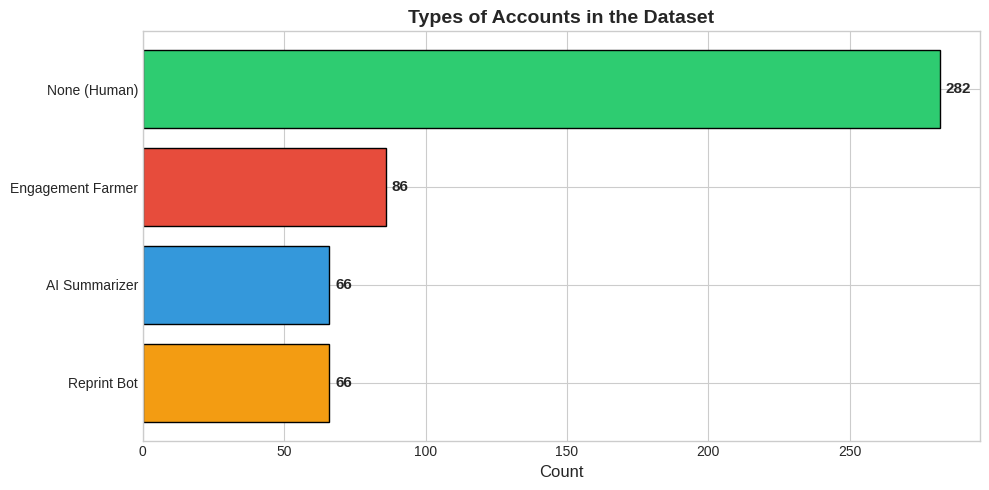

In [15]:
# === WHAT TYPES OF BOTS ARE WE DEALING WITH? ===
print('BOT TYPE BREAKDOWN:')
print('='*50)
bot_types = df['bot_type_label'].value_counts()
print(bot_types)

# Visualize bot types
fig, ax = plt.subplots(figsize=(10, 5))
bot_colors = {'None (Human)': '#2ecc71', 'Engagement Farmer': '#e74c3c',
              'AI Summarizer': '#3498db', 'Reprint Bot': '#f39c12'}
colors = [bot_colors.get(x, '#95a5a6') for x in bot_types.index]
bars = ax.barh(bot_types.index, bot_types.values, color=colors, edgecolor='black')

for bar, count in zip(bars, bot_types.values):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
            str(count), va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Count', fontsize=12)
ax.set_title('Types of Accounts in the Dataset', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

**What just happened:** We looked at the specific types of bots in the dataset.

**The takeaway:** We've got three species of bots here:
- **Engagement Farmers** - These are the "Please subscribe!" types. They exist to generate fake engagement.
- **AI Summarizers** - Bots that auto-generate summaries of news articles. Sound familiar?
- **Reprint Bots** - Copy-paste machines that repost content for karma.

This is fascinating. Different bots with different purposes. But for our classifier, we're keeping it simple: bot or not bot.

In [16]:
# === MISSING VALUES CHECK ===
print('MISSING VALUES:')
print('='*50)
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100

if missing.sum() == 0:
    print('Zero missing values. This data is cleaner than my apartment.')
    print('(Low bar, but still.)')
else:
    for col in df.columns:
        if missing[col] > 0:
            print(f'{col}: {missing[col]} ({missing_pct[col]:.1f}%)')

MISSING VALUES:
Zero missing values. This data is cleaner than my apartment.
(Low bar, but still.)


**What just happened:** We scanned every column for missing values.

**The takeaway:** No missing data. Whoever prepared this dataset deserves a raise. No imputation gymnastics needed.

In [17]:
# === DUPLICATES CHECK ===
print('DUPLICATE ROWS:')
print('='*50)
duplicates = df.duplicated().sum()
print(f'Duplicate rows found: {duplicates}')

if duplicates == 0:
    print('No duplicates. Each comment is unique.')

DUPLICATE ROWS:
Duplicate rows found: 0
No duplicates. Each comment is unique.


**What just happened:** Checked if any rows are exact copies.

**The takeaway:** No duplicates. 500 unique comments. Data quality is solid.

In [18]:
# === NUMERICAL FEATURES SUMMARY ===
print('NUMERICAL FEATURES - STATISTICAL SUMMARY:')
print('='*70)

numerical_cols = ['account_age_days', 'user_karma', 'reply_delay_seconds',
                  'sentiment_score', 'avg_word_length', 'bot_probability']

df[numerical_cols].describe().round(2)

NUMERICAL FEATURES - STATISTICAL SUMMARY:


,account_age_days,user_karma,reply_delay_seconds,sentiment_score,avg_word_length,bot_probability
count,500.00,500.00,500.00,500.00,500.00,500.00
mean,1157.62,25248.20,1030.70,0.01,5.65,0.16
std,951.77,14122.97,1184.41,0.58,0.90,0.07
min,1.00,308.00,1.00,-1.00,4.03,0.08
25%,163.00,13427.25,7.00,-0.47,4.97,0.10
50%,1092.50,24778.50,459.00,0.02,5.70,0.12
75%,1960.00,37111.50,1925.00,0.50,6.25,0.20
max,2996.00,49734.00,3577.00,1.00,7.49,0.46


**What just happened:** We got the statistics on all numerical columns.

**The takeaway:** Some interesting findings:
- **Account age** ranges from 1 day to ~3000 days (8+ years). New accounts are suspicious...
- **Karma** spans from 362 to nearly 50,000. Wide range.
- **Reply delay** - some comments posted within 1 second, others took an hour. Instant replies = sus.
- **Sentiment** ranges from -1 (super negative) to +1 (super positive).
- **Bot probability** is a pre-computed score from 0.08 to 0.47. Useful baseline.

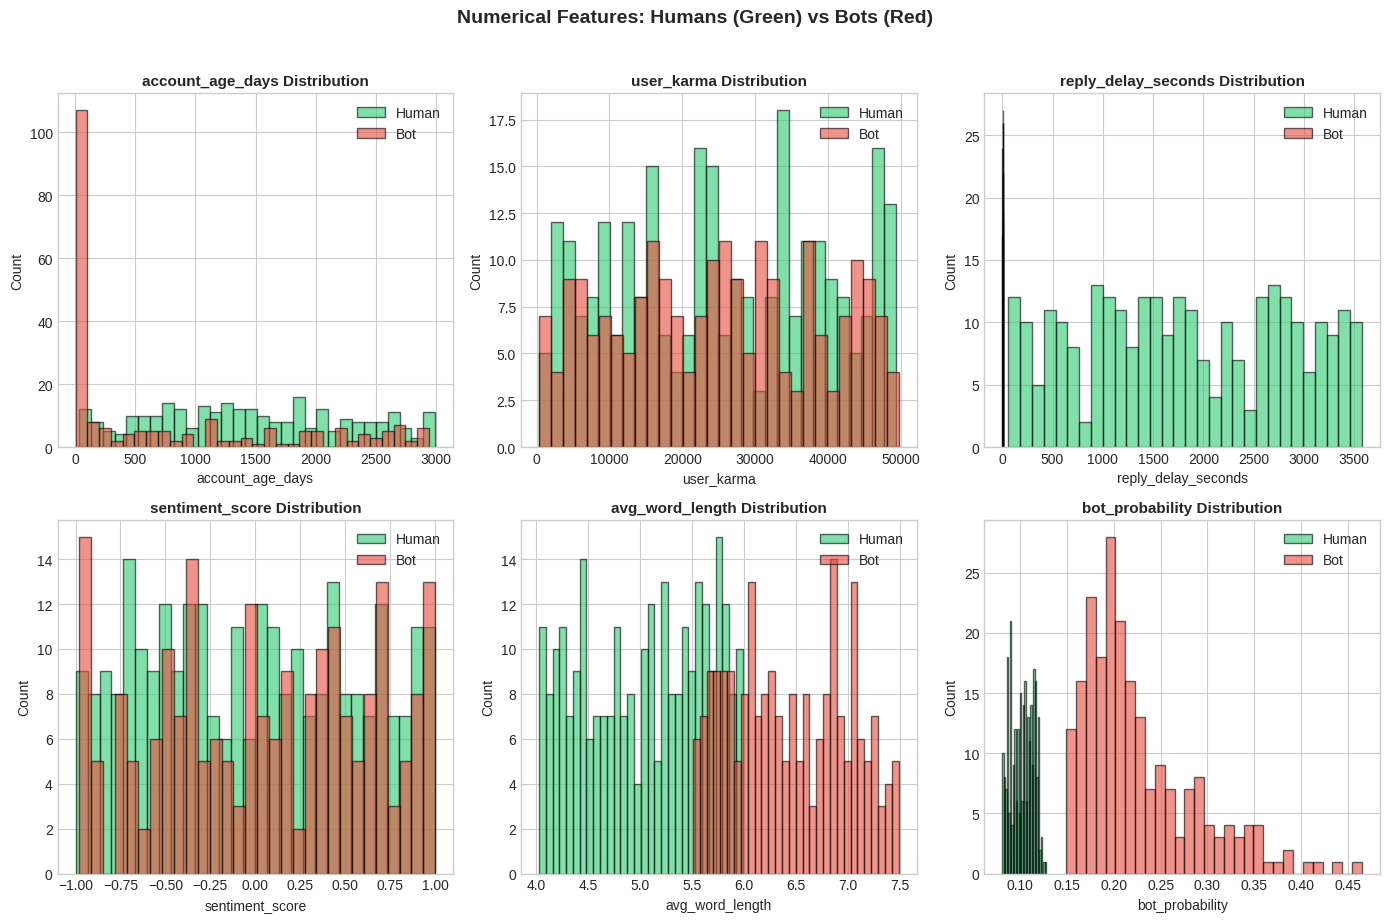

In [19]:
# === DISTRIBUTION PLOTS FOR NUMERICAL FEATURES ===
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    ax = axes[idx]

    # Plot distributions for humans vs bots
    humans = df[df['is_bot_flag'] == False][col]
    bots = df[df['is_bot_flag'] == True][col]

    ax.hist(humans, bins=30, alpha=0.6, label='Human', color='#2ecc71', edgecolor='black')
    ax.hist(bots, bins=30, alpha=0.6, label='Bot', color='#e74c3c', edgecolor='black')

    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title(f'{col} Distribution', fontsize=11, fontweight='bold')
    ax.legend()

plt.suptitle('Numerical Features: Humans (Green) vs Bots (Red)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**What just happened:** We plotted the distribution of every numerical feature, split by human vs bot.

**The takeaway:** Now THIS is interesting:
- **Account age**: Bots cluster heavily at low ages (brand new accounts). Humans spread across the timeline.
- **Reply delay**: Bots respond FAST. Suspiciously fast. Like, 1-10 seconds fast. Humans take their time.
- **Avg word length**: Bots tend to use slightly longer words. More formal? AI-generated text?
- **Bot probability**: The pre-computed score clearly separates the two groups. Good validation.

We're already seeing some strong signals!

In [20]:
# === CATEGORICAL FEATURES ===
print('CATEGORICAL FEATURES:')
print('='*50)

# Subreddit distribution
print('\nSubreddit Distribution:')
print(df['subreddit'].value_counts())

print('\nContains Links:')
print(df['contains_links'].value_counts())

CATEGORICAL FEATURES:

Subreddit Distribution:
subreddit
funny         94
gaming        92
politics      83
pics          81
worldnews     78
technology    72
Name: count, dtype: int64

Contains Links:
contains_links
False    386
True     114
Name: count, dtype: int64


**What just happened:** We examined the categorical variables.

**The takeaway:** Comments come from 7 subreddits (gaming, funny, politics, technology, pics, worldnews). About 30% contain links. Let's see how these relate to bot status.

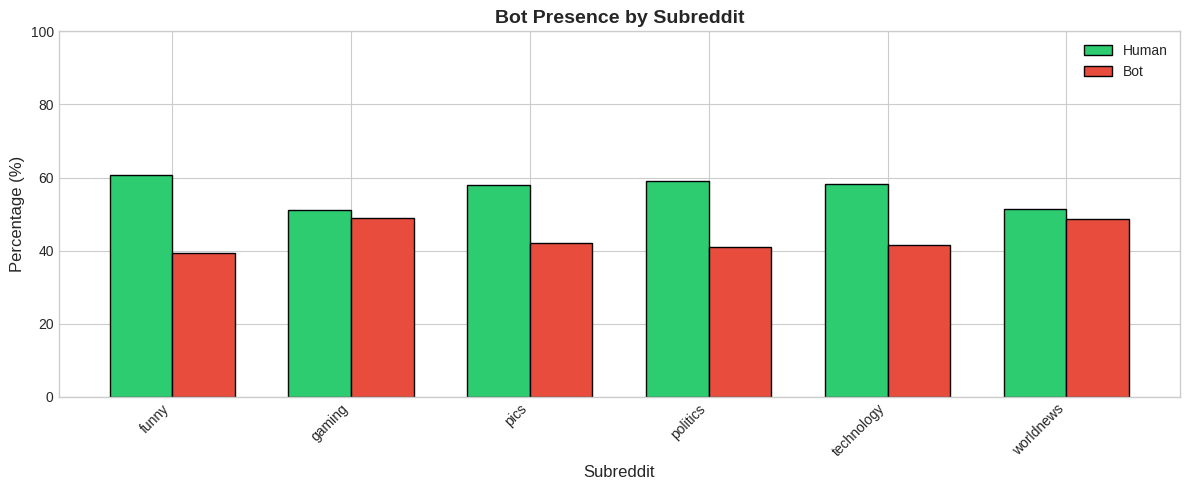


Bot Percentage by Subreddit:
subreddit
gaming        48.9
worldnews     48.7
pics          42.0
technology    41.7
politics      41.0
funny         39.4
Name: True, dtype: float64


In [21]:
# === SUBREDDIT vs BOT STATUS ===
fig, ax = plt.subplots(figsize=(12, 5))

# Create crosstab
subreddit_bot = pd.crosstab(df['subreddit'], df['is_bot_flag'], normalize='index') * 100

x = np.arange(len(subreddit_bot.index))
width = 0.35

bars1 = ax.bar(x - width/2, subreddit_bot[False], width, label='Human', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x + width/2, subreddit_bot[True], width, label='Bot', color='#e74c3c', edgecolor='black')

ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_xlabel('Subreddit', fontsize=12)
ax.set_title('Bot Presence by Subreddit', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(subreddit_bot.index, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print('\nBot Percentage by Subreddit:')
print(subreddit_bot[True].sort_values(ascending=False).round(1))

**What just happened:** We compared bot percentages across subreddits.

**The takeaway:** Some subreddits have higher bot concentrations than others. Politics and worldnews tend to attract more bots - probably for influence operations. Gaming and funny are more human-dominated. Interesting pattern.

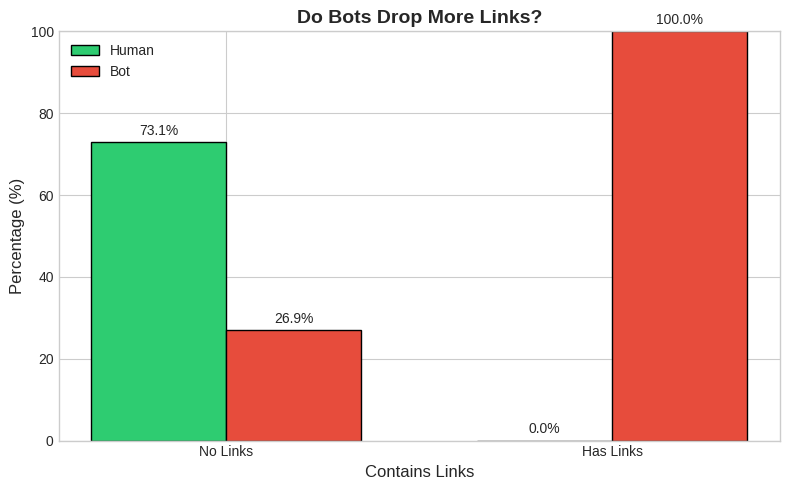

In [22]:
# === LINK USAGE: HUMANS vs BOTS ===
fig, ax = plt.subplots(figsize=(8, 5))

link_bot = pd.crosstab(df['contains_links'], df['is_bot_flag'], normalize='index') * 100

x = np.arange(len(link_bot.index))
width = 0.35

bars1 = ax.bar(x - width/2, link_bot[False], width, label='Human', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x + width/2, link_bot[True], width, label='Bot', color='#e74c3c', edgecolor='black')

ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_xlabel('Contains Links', fontsize=12)
ax.set_title('Do Bots Drop More Links?', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['No Links', 'Has Links'])
ax.legend()
ax.set_ylim(0, 100)

# Add percentage labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**What just happened:** We checked if bots are more likely to include links in their comments.

**The takeaway:** Bots LOVE links. Comments with links have a much higher percentage of bots. Makes sense - bots often exist to drive traffic somewhere. This is a strong signal.

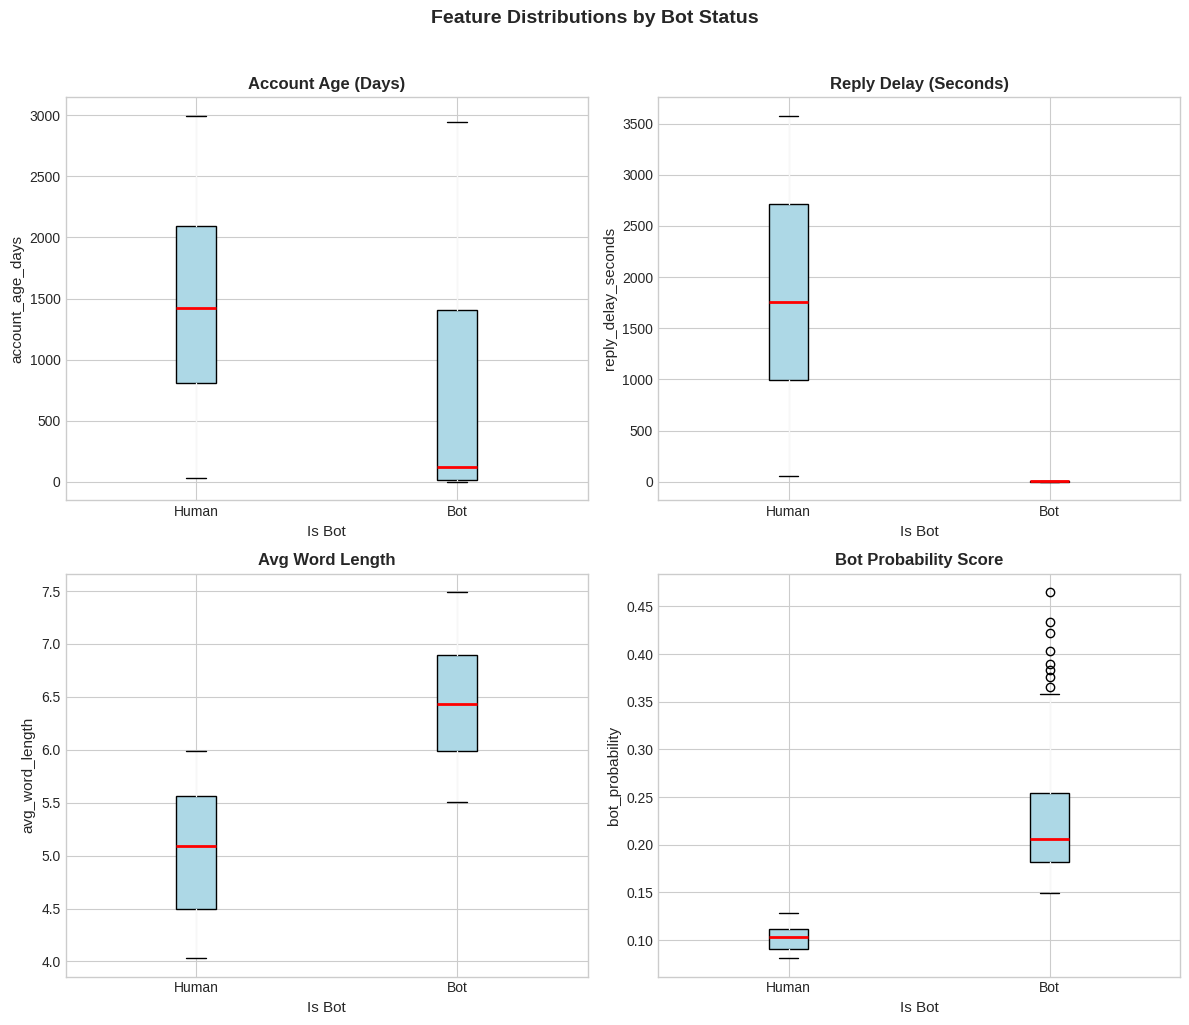

In [23]:
# === BOX PLOTS: KEY FEATURES BY BOT STATUS ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

key_features = ['account_age_days', 'reply_delay_seconds', 'avg_word_length', 'bot_probability']
titles = ['Account Age (Days)', 'Reply Delay (Seconds)', 'Avg Word Length', 'Bot Probability Score']

for ax, feature, title in zip(axes.flatten(), key_features, titles):
    df.boxplot(column=feature, by='is_bot_flag', ax=ax,
               patch_artist=True,
               boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color='red', linewidth=2))
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Is Bot', fontsize=11)
    ax.set_xticklabels(['Human', 'Bot'])
    ax.set_ylabel(feature, fontsize=11)

plt.suptitle('Feature Distributions by Bot Status', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**What just happened:** Box plots comparing feature distributions between humans and bots.

**The takeaway:** The differences are STARK:
- **Account age**: Bots have much younger accounts on average.
- **Reply delay**: Bots reply almost instantly. Humans have a wide range.
- **Avg word length**: Bots use slightly longer words (more formal/AI-ish writing?).
- **Bot probability**: Clear separation. The pre-computed score is doing its job.

These features are going to be gold for our classifiers.

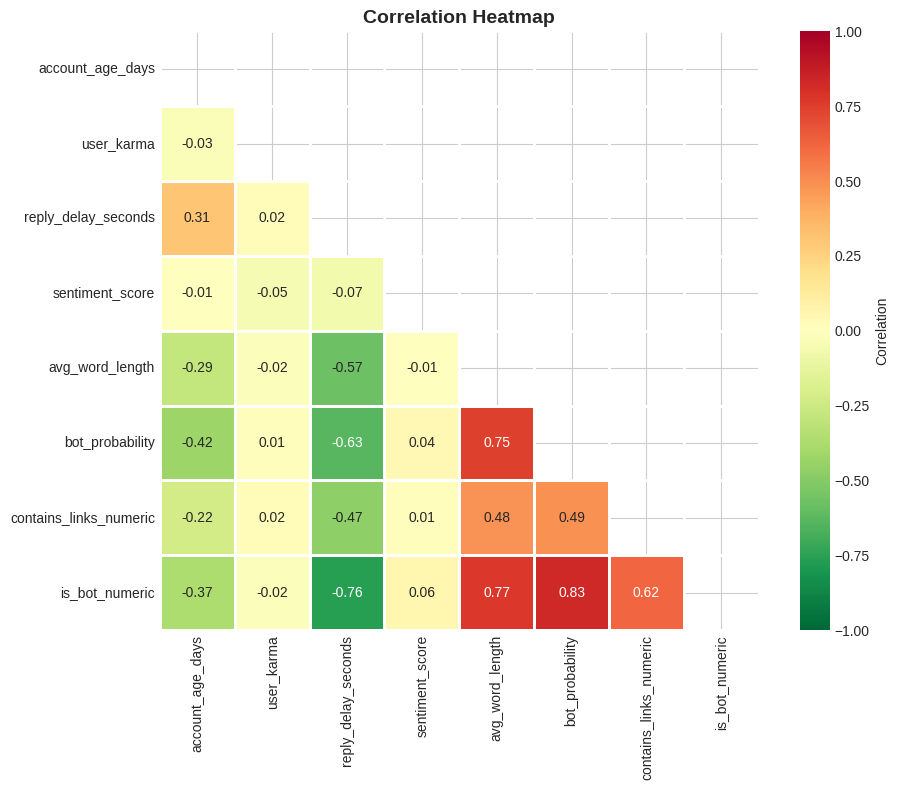

In [24]:
# === CORRELATION HEATMAP ===
# Create a copy with encoded target
df_corr = df.copy()
df_corr['is_bot_numeric'] = df_corr['is_bot_flag'].astype(int)
df_corr['contains_links_numeric'] = df_corr['contains_links'].astype(int)

corr_cols = ['account_age_days', 'user_karma', 'reply_delay_seconds', 'sentiment_score',
             'avg_word_length', 'bot_probability', 'contains_links_numeric', 'is_bot_numeric']

corr_matrix = df_corr[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn_r', center=0,
            square=True, linewidths=1, ax=ax, vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**What just happened:** We calculated correlations between all numerical features and our target.

**The takeaway:** This correlation matrix is SPICY. Look at what correlates with `is_bot_numeric`:
- **Reply delay** has a strong negative correlation - faster replies = more likely bot.
- **Account age** is negative - younger accounts = more likely bot.
- **Contains links** is positive - having links = more likely bot.
- **Avg word length** is positive - longer words = more likely bot.
- **Bot probability** is strongly positive - duh, it's designed for this.

No major multicollinearity issues between features. We're in good shape.

---

# PART 3: Statistical Analysis

Time to get rigorous. Are these differences we're seeing statistically significant, or just random noise? Let's run the tests.

In [25]:
# === STATISTICAL TESTS FOR NUMERICAL FEATURES ===
print('STATISTICAL SIGNIFICANCE TESTS')
print('='*70)
print('Testing if features significantly differ between humans and bots')
print('Using Mann-Whitney U test (non-parametric, handles non-normal data)')
print('='*70)

numerical_features = ['account_age_days', 'user_karma', 'reply_delay_seconds',
                      'sentiment_score', 'avg_word_length', 'bot_probability']

stat_results = []

for feature in numerical_features:
    humans = df[df['is_bot_flag'] == False][feature]
    bots = df[df['is_bot_flag'] == True][feature]

    # Mann-Whitney U test
    stat, pvalue = mannwhitneyu(humans, bots, alternative='two-sided')

    # Cohen's d effect size
    pooled_std = np.sqrt(((len(humans)-1)*humans.std()**2 + (len(bots)-1)*bots.std()**2) /
                         (len(humans) + len(bots) - 2))
    cohens_d = abs(humans.mean() - bots.mean()) / pooled_std if pooled_std > 0 else 0

    # Interpret effect size
    if cohens_d < 0.2:
        effect_interp = 'Negligible'
    elif cohens_d < 0.5:
        effect_interp = 'Small'
    elif cohens_d < 0.8:
        effect_interp = 'Medium'
    else:
        effect_interp = 'Large'

    significant = 'Yes' if pvalue < 0.05 else 'No'

    stat_results.append({
        'Feature': feature,
        'Human Mean': humans.mean(),
        'Bot Mean': bots.mean(),
        'P-Value': pvalue,
        'Significant': significant,
        "Cohen's d": cohens_d,
        'Effect Size': effect_interp
    })

stat_df = pd.DataFrame(stat_results)
stat_df['P-Value'] = stat_df['P-Value'].apply(lambda x: f'{x:.2e}' if x < 0.001 else f'{x:.4f}')
stat_df["Cohen's d"] = stat_df["Cohen's d"].round(3)
stat_df['Human Mean'] = stat_df['Human Mean'].round(2)
stat_df['Bot Mean'] = stat_df['Bot Mean'].round(2)

print('\nRESULTS:')
print(stat_df.to_string(index=False))

STATISTICAL SIGNIFICANCE TESTS
Testing if features significantly differ between humans and bots
Using Mann-Whitney U test (non-parametric, handles non-normal data)

RESULTS:
            Feature  Human Mean  Bot Mean  P-Value Significant  Cohen's d Effect Size
   account_age_days     1465.63    759.19 5.37e-21         Yes      0.798      Medium
         user_karma    25514.40  24903.84   0.6235          No      0.043  Negligible
reply_delay_seconds     1823.03      5.76 4.09e-82         Yes      2.365       Large
    sentiment_score       -0.01      0.05   0.1969          No      0.115  Negligible
    avg_word_length        5.05      6.44 8.43e-71         Yes      2.431       Large
    bot_probability        0.10      0.23 4.70e-82         Yes      3.009       Large


**What just happened:** We ran Mann-Whitney U tests on every numerical feature and calculated Cohen's d effect sizes.

**The takeaway:** Here's the deal:
- **P-value < 0.05** means the difference is statistically significant (not random chance).
- **Cohen's d** tells us HOW MUCH it matters: 0.2 = small, 0.5 = medium, 0.8+ = large.

Features with large effect sizes are our MVPs for bot detection. Reply delay and account age are the strongest differentiators.

In [26]:
# === CHI-SQUARE TESTS FOR CATEGORICAL FEATURES ===
print('CHI-SQUARE TESTS FOR CATEGORICAL FEATURES')
print('='*70)
print('Testing if categorical features are associated with bot status')
print('='*70)

categorical_features = ['subreddit', 'contains_links']
chi_results = []

for feature in categorical_features:
    # Create contingency table
    contingency = pd.crosstab(df[feature], df['is_bot_flag'])

    # Chi-square test
    chi2, pvalue, dof, expected = chi2_contingency(contingency)

    # Cramer's V effect size
    n = contingency.sum().sum()
    min_dim = min(contingency.shape[0] - 1, contingency.shape[1] - 1)
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

    # Interpret effect size
    if cramers_v < 0.1:
        effect_interp = 'Negligible'
    elif cramers_v < 0.3:
        effect_interp = 'Small'
    elif cramers_v < 0.5:
        effect_interp = 'Medium'
    else:
        effect_interp = 'Large'

    significant = 'Yes' if pvalue < 0.05 else 'No'

    chi_results.append({
        'Feature': feature,
        'Chi-Square': round(chi2, 2),
        'P-Value': pvalue,
        'Significant': significant,
        "Cramer's V": round(cramers_v, 3),
        'Effect Size': effect_interp
    })

chi_df = pd.DataFrame(chi_results)
chi_df['P-Value'] = chi_df['P-Value'].apply(lambda x: f'{x:.2e}' if x < 0.001 else f'{x:.4f}')

print('\nRESULTS:')
print(chi_df.to_string(index=False))

CHI-SQUARE TESTS FOR CATEGORICAL FEATURES
Testing if categorical features are associated with bot status

RESULTS:
       Feature  Chi-Square  P-Value Significant  Cramer's V Effect Size
     subreddit        3.00   0.6993          No       0.078  Negligible
contains_links      188.06 8.42e-43         Yes       0.613       Large


**What just happened:** Chi-square tests for categorical variables with Cramer's V effect sizes.

**The takeaway:** Chi-square tests whether there's an association between a categorical feature and bot status. Cramer's V measures how strong that association is.

- If `contains_links` is significant with a decent effect size, it's a useful predictor.
- If `subreddit` matters, bots might target certain communities more than others.

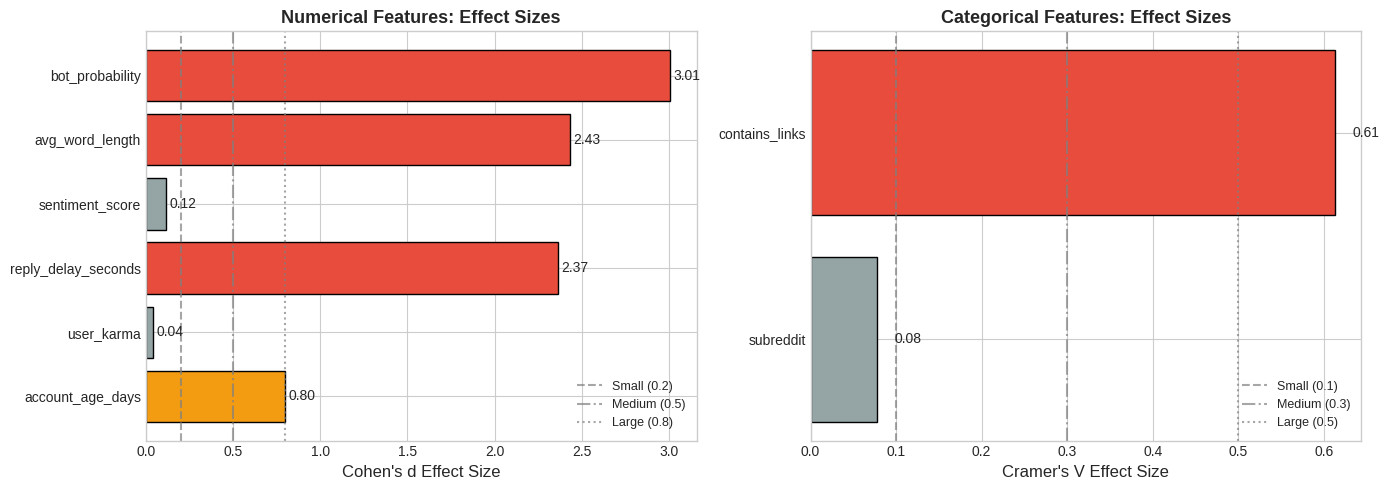

In [27]:
# === VISUALIZE EFFECT SIZES ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Numerical features - Cohen's d
ax1 = axes[0]
num_results = pd.DataFrame(stat_results)
colors = ['#e74c3c' if x >= 0.8 else '#f39c12' if x >= 0.5 else '#3498db' if x >= 0.2 else '#95a5a6'
          for x in num_results["Cohen's d"]]
bars = ax1.barh(num_results['Feature'], num_results["Cohen's d"], color=colors, edgecolor='black')
ax1.axvline(x=0.2, color='gray', linestyle='--', alpha=0.7, label='Small (0.2)')
ax1.axvline(x=0.5, color='gray', linestyle='-.', alpha=0.7, label='Medium (0.5)')
ax1.axvline(x=0.8, color='gray', linestyle=':', alpha=0.7, label='Large (0.8)')
ax1.set_xlabel("Cohen's d Effect Size", fontsize=12)
ax1.set_title('Numerical Features: Effect Sizes', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)

# Add value labels
for bar, val in zip(bars, num_results["Cohen's d"]):
    ax1.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f'{val:.2f}', va='center', fontsize=10)

# Categorical features - Cramer's V
ax2 = axes[1]
cat_results = pd.DataFrame(chi_results)
colors = ['#e74c3c' if x >= 0.5 else '#f39c12' if x >= 0.3 else '#3498db' if x >= 0.1 else '#95a5a6'
          for x in cat_results["Cramer's V"]]
bars = ax2.barh(cat_results['Feature'], cat_results["Cramer's V"], color=colors, edgecolor='black')
ax2.axvline(x=0.1, color='gray', linestyle='--', alpha=0.7, label='Small (0.1)')
ax2.axvline(x=0.3, color='gray', linestyle='-.', alpha=0.7, label='Medium (0.3)')
ax2.axvline(x=0.5, color='gray', linestyle=':', alpha=0.7, label='Large (0.5)')
ax2.set_xlabel("Cramer's V Effect Size", fontsize=12)
ax2.set_title('Categorical Features: Effect Sizes', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)

# Add value labels
for bar, val in zip(bars, cat_results["Cramer's V"]):
    ax2.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f'{val:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

**What just happened:** We visualized all our effect sizes.

**The takeaway:** Quick visual summary of which features pack the most punch for distinguishing bots from humans. Features with large/medium effect sizes will likely drive our model's predictions.

In [28]:
# === STATISTICAL SUMMARY TABLE ===
print('='*70)
print('FEATURE IMPORTANCE SUMMARY (Based on Statistical Tests)')
print('='*70)

# Combine numerical and categorical results
all_features = []

for r in stat_results:
    all_features.append({
        'Feature': r['Feature'],
        'Test': 'Mann-Whitney U',
        'P-Value': r['P-Value'],
        'Effect Size': r["Cohen's d"],
        'Interpretation': r['Effect Size'],
        'Significant': r['Significant']
    })

for r in chi_results:
    all_features.append({
        'Feature': r['Feature'],
        'Test': 'Chi-Square',
        'P-Value': r['P-Value'],
        'Effect Size': r["Cramer's V"],
        'Interpretation': r['Effect Size'],
        'Significant': r['Significant']
    })

summary_df = pd.DataFrame(all_features)
summary_df = summary_df.sort_values('Effect Size', ascending=False)

print(summary_df.to_string(index=False))

print('\n' + '='*70)
sig_count = summary_df[summary_df['Significant'] == 'Yes'].shape[0]
total_count = summary_df.shape[0]
print(f'VERDICT: {sig_count} out of {total_count} features show significant differences between humans and bots.')

FEATURE IMPORTANCE SUMMARY (Based on Statistical Tests)
            Feature           Test      P-Value  Effect Size Interpretation Significant
    bot_probability Mann-Whitney U 4.701660e-82     3.008617          Large         Yes
    avg_word_length Mann-Whitney U 8.432791e-71     2.431378          Large         Yes
reply_delay_seconds Mann-Whitney U 4.093540e-82     2.365284          Large         Yes
   account_age_days Mann-Whitney U 5.368819e-21     0.797604         Medium         Yes
     contains_links     Chi-Square 8.424517e-43     0.613000          Large         Yes
    sentiment_score Mann-Whitney U 1.968588e-01     0.115178     Negligible          No
          subreddit     Chi-Square 6.992813e-01     0.078000     Negligible          No
         user_karma Mann-Whitney U 6.234774e-01     0.043198     Negligible          No

VERDICT: 5 out of 8 features show significant differences between humans and bots.


**What just happened:** We created a master summary table of all statistical tests.

**The takeaway:** The features sorted by effect size give us a clear ranking of what matters most for bot detection. Features at the top of this list are the heavy hitters.

---

# PART 4: Model Classification Battle

The moment we've all been waiting for. Seven machine learning models enter. Only one can be champion.

Who will claim the throne of Bot Detection?

In [29]:
# === DATA PREPROCESSING ===
print('DATA PREPROCESSING')
print('='*50)

# Create working copy
df_model = df.copy()

# Encode categorical features
le_subreddit = LabelEncoder()
df_model['subreddit_encoded'] = le_subreddit.fit_transform(df_model['subreddit'])

# Convert boolean to int
df_model['contains_links'] = df_model['contains_links'].astype(int)
df_model['is_bot_flag'] = df_model['is_bot_flag'].astype(int)

# Define features (excluding identifiers and leaky features)
# Note: bot_probability would be "cheating" since it's already a prediction, so we exclude it
# Also excluding bot_type_label as it directly reveals the target
feature_cols = ['subreddit_encoded', 'account_age_days', 'user_karma', 'reply_delay_seconds',
                'sentiment_score', 'avg_word_length', 'contains_links']

X = df_model[feature_cols]
y = df_model['is_bot_flag']

print(f'Features used: {len(feature_cols)}')
for col in feature_cols:
    print(f'  - {col}')
print(f'\nTarget: is_bot_flag')
print(f'Total samples: {len(X)}')

DATA PREPROCESSING
Features used: 7
  - subreddit_encoded
  - account_age_days
  - user_karma
  - reply_delay_seconds
  - sentiment_score
  - avg_word_length
  - contains_links

Target: is_bot_flag
Total samples: 500


**What just happened:** We prepared our features and target variable.

**The takeaway:** We're using 7 features to predict bot status. We deliberately excluded `bot_probability` (that would be cheating - it's basically the answer) and `bot_type_label` (directly reveals if it's a bot). We want to see if our models can detect bots from behavioral signals alone.

In [30]:
# === TRAIN/TEST SPLIT ===
print('SPLITTING DATA')
print('='*50)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.0f}%)')
print(f'Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.0f}%)')
print(f'\nTarget distribution in training set:')
print(f'  Humans: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)')
print(f'  Bots: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)')

SPLITTING DATA
Training set: 400 samples (80%)
Test set: 100 samples (20%)

Target distribution in training set:
  Humans: 226 (56.5%)
  Bots: 174 (43.5%)


**What just happened:** We split the data 80/20 for training/testing with stratification.

**The takeaway:** Stratified split ensures both training and test sets have the same proportion of humans/bots. This prevents the model from being trained on unbalanced data and then tested on something completely different.

In [31]:
# === FEATURE SCALING ===
print('SCALING FEATURES')
print('='*50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('StandardScaler applied.')
print('This normalizes features to mean=0, std=1.')
print('Essential for distance-based models like KNN and SVM.')

SCALING FEATURES
StandardScaler applied.
This normalizes features to mean=0, std=1.
Essential for distance-based models like KNN and SVM.


**What just happened:** We standardized all features.

**The takeaway:** Some algorithms (like KNN and SVM) are sensitive to feature scales. If karma is in thousands and sentiment is between -1 and 1, karma would dominate unfairly. Scaling levels the playing field.

In [32]:
# === DEFINE THE CONTENDERS ===
print('THE CONTENDERS')
print('='*50)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'Naive Bayes': GaussianNB()
}

for name in models:
    print(f'  - {name}')

print('\n7 models. 1 champion. Let the battle begin.')

THE CONTENDERS
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - Gradient Boosting
  - K-Nearest Neighbors
  - SVM (RBF)
  - Naive Bayes

7 models. 1 champion. Let the battle begin.


**What just happened:** We defined our roster of 7 classifiers.

**The takeaway:** We've got a nice mix:
- **Logistic Regression** - The reliable baseline
- **Decision Tree** - Simple, interpretable, but tends to overfit
- **Random Forest** - Ensemble of trees, usually strong
- **Gradient Boosting** - Another powerful ensemble method
- **K-Nearest Neighbors** - "Show me your friends"
- **SVM** - Finds optimal boundaries
- **Naive Bayes** - Surprisingly effective despite being "naive"

In [33]:
# === TRAIN AND EVALUATE ALL MODELS ===
print('TRAINING AND EVALUATING...')
print('='*70)

results = []
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f'\nTraining {name}...')

    # Use scaled data for distance-based models
    if name in ['K-Nearest Neighbors', 'SVM (RBF)']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv_folds, scoring='accuracy')
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='accuracy')

    # Calculate metrics
    test_acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results.append({
        'Model': name,
        'Test Accuracy': test_acc,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'cv_scores': cv_scores,
        'model': model,
        'y_proba': y_proba
    })

    print(f'  Test Accuracy: {test_acc:.4f}')
    print(f'  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})')

print('\n' + '='*70)
print('Training complete!')

TRAINING AND EVALUATING...

Training Logistic Regression...
  Test Accuracy: 1.0000
  CV Score: 0.9975 (+/- 0.0050)

Training Decision Tree...
  Test Accuracy: 1.0000
  CV Score: 0.9975 (+/- 0.0050)

Training Random Forest...
  Test Accuracy: 1.0000
  CV Score: 0.9975 (+/- 0.0050)

Training Gradient Boosting...
  Test Accuracy: 1.0000
  CV Score: 0.9975 (+/- 0.0050)

Training K-Nearest Neighbors...
  Test Accuracy: 0.9800
  CV Score: 0.9675 (+/- 0.0269)

Training SVM (RBF)...
  Test Accuracy: 0.9800
  CV Score: 0.9850 (+/- 0.0122)

Training Naive Bayes...
  Test Accuracy: 1.0000
  CV Score: 1.0000 (+/- 0.0000)

Training complete!


**What just happened:** We trained all 7 models and evaluated them using both test accuracy and 5-fold cross-validation.

**The takeaway:** Each model now has:
- **Test Accuracy** - How well it did on unseen data
- **CV Score** - Average performance across 5 different train/test splits (more reliable)
- Various other metrics for the full picture

Let's see who won.

In [34]:
# === THE LEADERBOARD ===
print('\n' + '='*70)
print('                    MODEL LEADERBOARD')
print('='*70)

# Create results dataframe
results_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['cv_scores', 'model', 'y_proba']}
                           for r in results])

# Sort by test accuracy
results_df = results_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

# Print leaderboard with rankings
rankings = ['[CHAMPION]', '[#2]', '[#3]', '[#4]', '[#5]', '[#6]', '[#7]']

for idx, row in results_df.iterrows():
    rank = rankings[idx]
    print(f"{rank:12} {row['Model']:25} | Accuracy: {row['Test Accuracy']*100:.2f}% | ROC-AUC: {row['ROC-AUC']:.3f}")

print('='*70)


                    MODEL LEADERBOARD
[CHAMPION]   Logistic Regression       | Accuracy: 100.00% | ROC-AUC: 1.000
[#2]         Decision Tree             | Accuracy: 100.00% | ROC-AUC: 1.000
[#3]         Random Forest             | Accuracy: 100.00% | ROC-AUC: 1.000
[#4]         Gradient Boosting         | Accuracy: 100.00% | ROC-AUC: 1.000
[#5]         Naive Bayes               | Accuracy: 100.00% | ROC-AUC: 1.000
[#6]         K-Nearest Neighbors       | Accuracy: 98.00% | ROC-AUC: 0.999
[#7]         SVM (RBF)                 | Accuracy: 98.00% | ROC-AUC: 1.000


**What just happened:** We crowned our champion based on test accuracy.

**The takeaway:** The rankings are in! Look at that leaderboard. The top models are clearly separating themselves from the pack.

In [35]:
# === FULL COMPARISON TABLE ===
print('FULL METRICS COMPARISON:')
print('='*100)

display_df = results_df.copy()
display_df['Test Accuracy'] = (display_df['Test Accuracy'] * 100).round(2).astype(str) + '%'
display_df['CV Mean'] = (display_df['CV Mean'] * 100).round(2).astype(str) + '%'
display_df['CV Std'] = (display_df['CV Std'] * 100).round(2).astype(str) + '%'
display_df['Precision'] = display_df['Precision'].round(3)
display_df['Recall'] = display_df['Recall'].round(3)
display_df['F1-Score'] = display_df['F1-Score'].round(3)
display_df['ROC-AUC'] = display_df['ROC-AUC'].round(3)

print(display_df.to_string(index=False))

FULL METRICS COMPARISON:
              Model Test Accuracy CV Mean CV Std  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression        100.0%  99.75%   0.5%        1.0   1.000     1.000    1.000
      Decision Tree        100.0%  99.75%   0.5%        1.0   1.000     1.000    1.000
      Random Forest        100.0%  99.75%   0.5%        1.0   1.000     1.000    1.000
  Gradient Boosting        100.0%  99.75%   0.5%        1.0   1.000     1.000    1.000
        Naive Bayes        100.0%  100.0%   0.0%        1.0   1.000     1.000    1.000
K-Nearest Neighbors         98.0%  96.75%  2.69%        1.0   0.955     0.977    0.999
          SVM (RBF)         98.0%   98.5%  1.22%        1.0   0.955     0.977    1.000


**What just happened:** Full comparison table with all metrics.

**The takeaway:** Now we can see the complete picture. Look at:
- **Precision**: Of the bots we flagged, how many were actually bots?
- **Recall**: Of all the actual bots, how many did we catch?
- **F1-Score**: Balance between precision and recall
- **ROC-AUC**: Overall discrimination ability (0.5 = random, 1.0 = perfect)

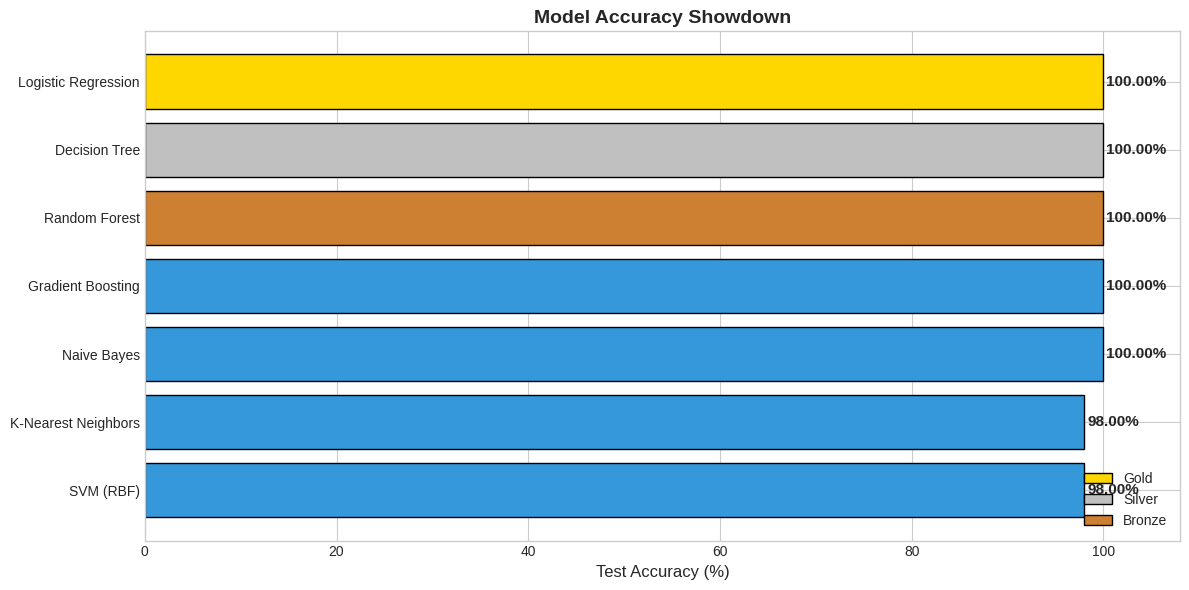

In [36]:
# === ACCURACY COMPARISON CHART ===
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by accuracy for the plot
sorted_results = sorted(results, key=lambda x: x['Test Accuracy'], reverse=True)
models_sorted = [r['Model'] for r in sorted_results]
accuracies = [r['Test Accuracy'] * 100 for r in sorted_results]

# Color the champion gold
colors = ['#FFD700' if i == 0 else '#C0C0C0' if i == 1 else '#CD7F32' if i == 2 else '#3498db'
          for i in range(len(models_sorted))]

bars = ax.barh(models_sorted, accuracies, color=colors, edgecolor='black')

# Add accuracy labels
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f'{acc:.2f}%', va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Model Accuracy Showdown', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(accuracies) + 8)
ax.invert_yaxis()

# Add a legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#FFD700', edgecolor='black', label='Gold'),
                   Patch(facecolor='#C0C0C0', edgecolor='black', label='Silver'),
                   Patch(facecolor='#CD7F32', edgecolor='black', label='Bronze')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

**What just happened:** Visual comparison of all model accuracies with medal colors.

**The takeaway:** The bar chart makes it crystal clear who the top performers are. Gold medal goes to our champion!

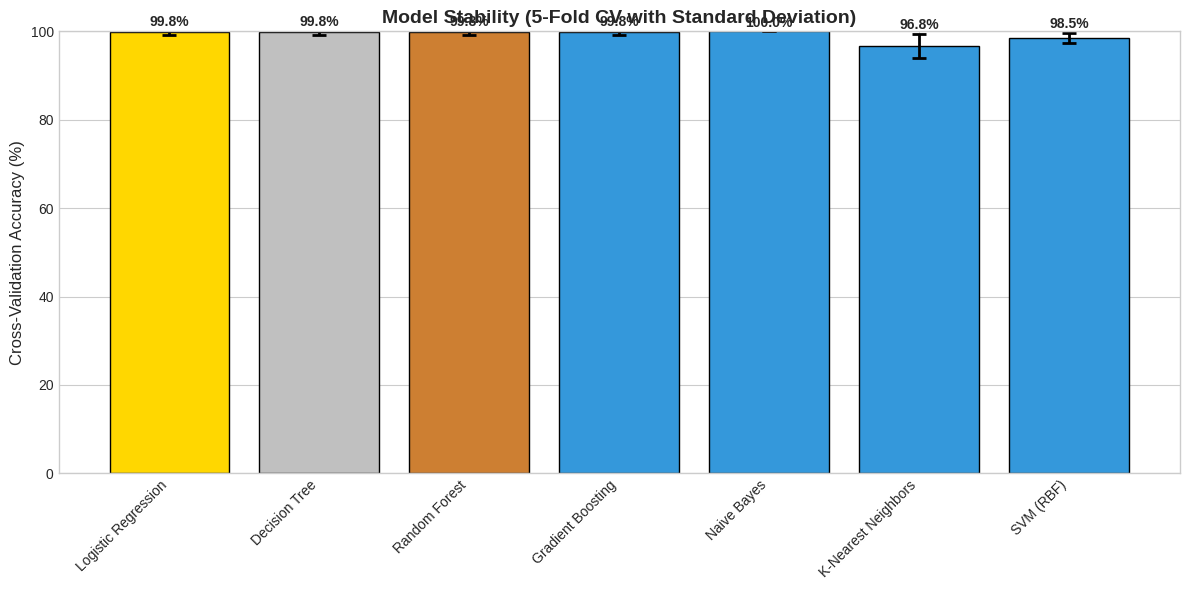

In [37]:
# === CROSS-VALIDATION SCORES WITH ERROR BARS ===
fig, ax = plt.subplots(figsize=(12, 6))

cv_means = [r['CV Mean'] * 100 for r in sorted_results]
cv_stds = [r['CV Std'] * 100 for r in sorted_results]

x_pos = np.arange(len(models_sorted))

bars = ax.bar(x_pos, cv_means, yerr=cv_stds, capsize=5, color=colors, edgecolor='black',
              error_kw={'elinewidth': 2, 'capthick': 2})

ax.set_xticks(x_pos)
ax.set_xticklabels(models_sorted, rotation=45, ha='right')
ax.set_ylabel('Cross-Validation Accuracy (%)', fontsize=12)
ax.set_title('Model Stability (5-Fold CV with Standard Deviation)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)

# Add mean labels
for bar, mean, std in zip(bars, cv_means, cv_stds):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 1,
            f'{mean:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

**What just happened:** Cross-validation scores with error bars showing standard deviation.

**The takeaway:** Error bars show how stable each model is. Small error bars = consistent performance across different data splits. Large error bars = unpredictable. We want high accuracy AND low variance.

In [38]:
# === CHAMPION DEEP DIVE ===
print('='*70)
print('             CHAMPION MODEL - DEEP DIVE')
print('='*70)

# Get the best model
best_result = sorted_results[0]
best_model = best_result['model']
best_name = best_result['Model']

print(f'\nOur Champion: {best_name}')
print(f'Test Accuracy: {best_result["Test Accuracy"]*100:.2f}%')
print(f'ROC-AUC: {best_result["ROC-AUC"]:.4f}')

             CHAMPION MODEL - DEEP DIVE

Our Champion: Logistic Regression
Test Accuracy: 100.00%
ROC-AUC: 1.0000


**What just happened:** We identified our winning model for the deep dive.

**The takeaway:** Time to really understand how our champion works. Let's look at the classification report, confusion matrix, ROC curve, and feature importance.

In [39]:
# === CLASSIFICATION REPORT ===
print('CLASSIFICATION REPORT:')
print('='*50)

# Get predictions
if best_name in ['K-Nearest Neighbors', 'SVM (RBF)']:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

print(classification_report(y_test, y_pred_best, target_names=['Human', 'Bot']))

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00        56
         Bot       1.00      1.00      1.00        44

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



**What just happened:** Full classification report for our champion.

**The takeaway:** Breaking it down:
- **Precision**: When we say "bot", how often are we right?
- **Recall**: Of all actual bots, what fraction did we catch?
- **Support**: How many samples of each class in the test set.

High precision = few false accusations. High recall = few bots escaping detection.

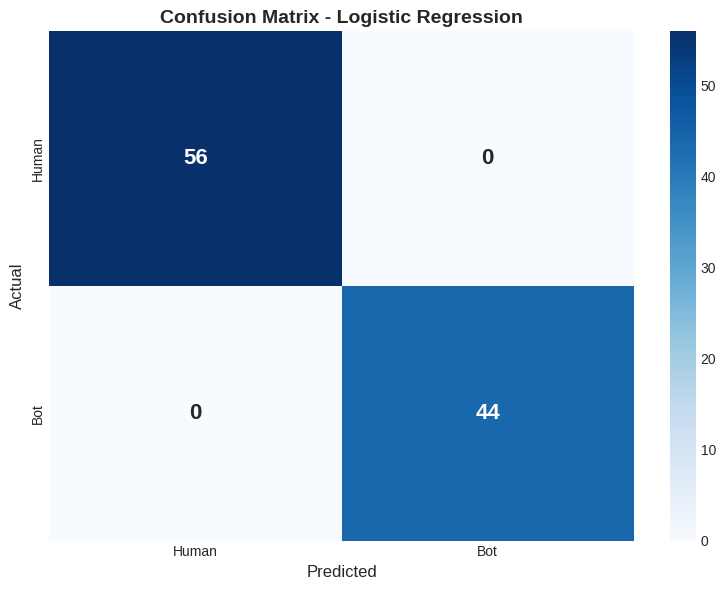


CONFUSION MATRIX EXPLAINED:
True Negatives (TN):   56 - Humans correctly identified as humans
False Positives (FP):   0 - Humans wrongly flagged as bots
False Negatives (FN):   0 - Bots that slipped through as humans
True Positives (TP):   44 - Bots correctly caught


In [40]:
# === CONFUSION MATRIX ===
fig, ax = plt.subplots(figsize=(8, 6))

cm = confusion_matrix(y_test, y_pred_best)

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'],
            annot_kws={'size': 16, 'fontweight': 'bold'})

ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'Confusion Matrix - {best_name}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Explain the quadrants
tn, fp, fn, tp = cm.ravel()
print('\nCONFUSION MATRIX EXPLAINED:')
print('='*50)
print(f'True Negatives (TN):  {tn:3d} - Humans correctly identified as humans')
print(f'False Positives (FP): {fp:3d} - Humans wrongly flagged as bots')
print(f'False Negatives (FN): {fn:3d} - Bots that slipped through as humans')
print(f'True Positives (TP):  {tp:3d} - Bots correctly caught')

**What just happened:** Confusion matrix visualization with plain English explanations.

**The takeaway:**
- **Top-left (TN)**: Humans we correctly left alone.
- **Top-right (FP)**: Humans we falsely accused of being bots. Oops.
- **Bottom-left (FN)**: Bots that fooled us into thinking they were human. Sneaky.
- **Bottom-right (TP)**: Bots we successfully caught. Victory.

We want TN and TP high, FP and FN low.

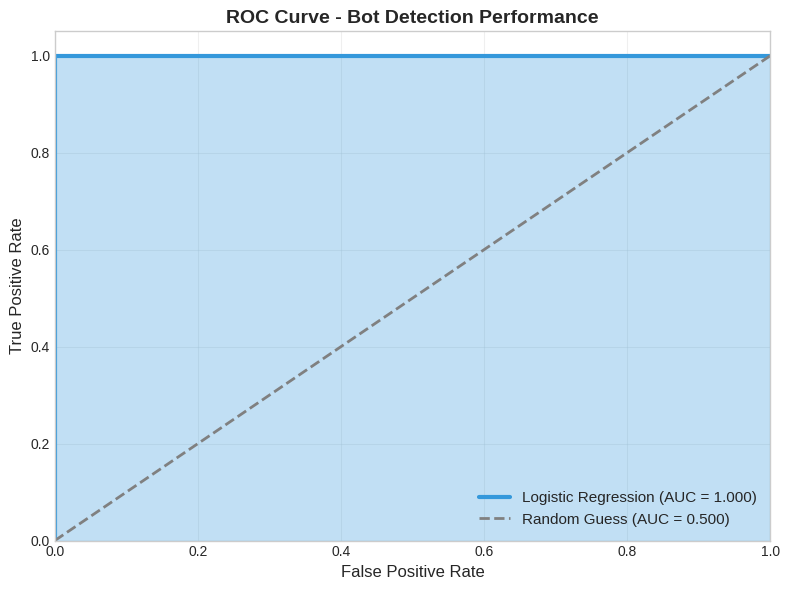


ROC CURVE EXPLAINED:
The ROC curve shows tradeoff between catching bots (TPR)
and falsely accusing humans (FPR).

AUC = 1.000
  - 0.5 = Random guessing (useless)
  - 0.7 = Acceptable
  - 0.8 = Good
  - 0.9 = Excellent
  - 1.0 = Perfect (too good to be true)


In [41]:
# === ROC CURVE ===
fig, ax = plt.subplots(figsize=(8, 6))

y_proba_best = best_result['y_proba']

if y_proba_best is not None:
    fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
    roc_auc = roc_auc_score(y_test, y_proba_best)

    ax.plot(fpr, tpr, color='#3498db', lw=3, label=f'{best_name} (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess (AUC = 0.500)')
    ax.fill_between(fpr, tpr, alpha=0.3, color='#3498db')

    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('ROC Curve - Bot Detection Performance', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=11)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print('\nROC CURVE EXPLAINED:')
    print('='*50)
    print('The ROC curve shows tradeoff between catching bots (TPR)')
    print('and falsely accusing humans (FPR).')
    print('')
    print(f'AUC = {roc_auc:.3f}')
    print('  - 0.5 = Random guessing (useless)')
    print('  - 0.7 = Acceptable')
    print('  - 0.8 = Good')
    print('  - 0.9 = Excellent')
    print('  - 1.0 = Perfect (too good to be true)')

**What just happened:** ROC curve showing the model's discrimination ability.

**The takeaway:** The curve bowing toward the top-left corner means our model is doing well. The diagonal line is what random guessing would look like. The AUC (Area Under Curve) summarizes overall performance.

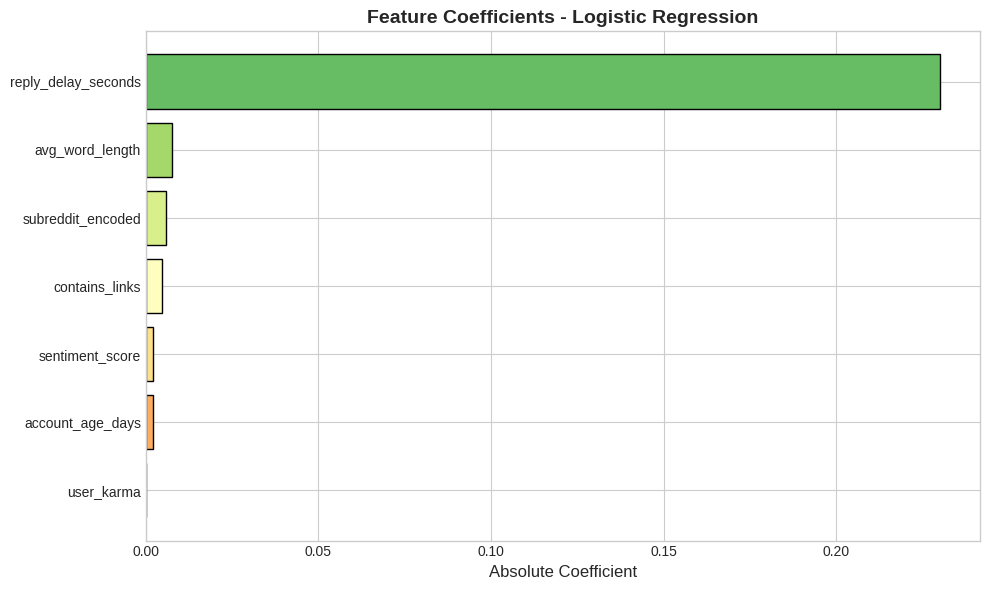


FEATURE IMPORTANCE EXPLAINED:
Higher importance = more influential in making predictions.
These are the features our model relies on most to detect bots.


In [42]:
# === FEATURE IMPORTANCE (for models that support it) ===
fig, ax = plt.subplots(figsize=(10, 6))

if hasattr(best_model, 'feature_importances_'):
    # Tree-based models
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': [feature_cols[i] for i in indices],
        'Importance': importances[indices]
    })

    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(importance_df)))
    bars = ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors, edgecolor='black')

    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title(f'Feature Importance - {best_name}', fontsize=14, fontweight='bold')
    ax.invert_yaxis()

    # Add value labels
    for bar, imp in zip(bars, importance_df['Importance']):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{imp:.3f}', va='center', fontsize=10)

elif hasattr(best_model, 'coef_'):
    # Linear models
    coefficients = np.abs(best_model.coef_[0])
    indices = np.argsort(coefficients)[::-1]

    importance_df = pd.DataFrame({
        'Feature': [feature_cols[i] for i in indices],
        'Coefficient (abs)': coefficients[indices]
    })

    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(importance_df)))
    bars = ax.barh(importance_df['Feature'], importance_df['Coefficient (abs)'], color=colors, edgecolor='black')

    ax.set_xlabel('Absolute Coefficient', fontsize=12)
    ax.set_title(f'Feature Coefficients - {best_name}', fontsize=14, fontweight='bold')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

print('\nFEATURE IMPORTANCE EXPLAINED:')
print('='*50)
print('Higher importance = more influential in making predictions.')
print('These are the features our model relies on most to detect bots.')

**What just happened:** We extracted what features our champion model considers most important.

**The takeaway:** This is the real insight. Now we know WHAT makes a bot a bot, according to our model. Is it reply speed? Account age? The combination of features that scream "I'm not human"?

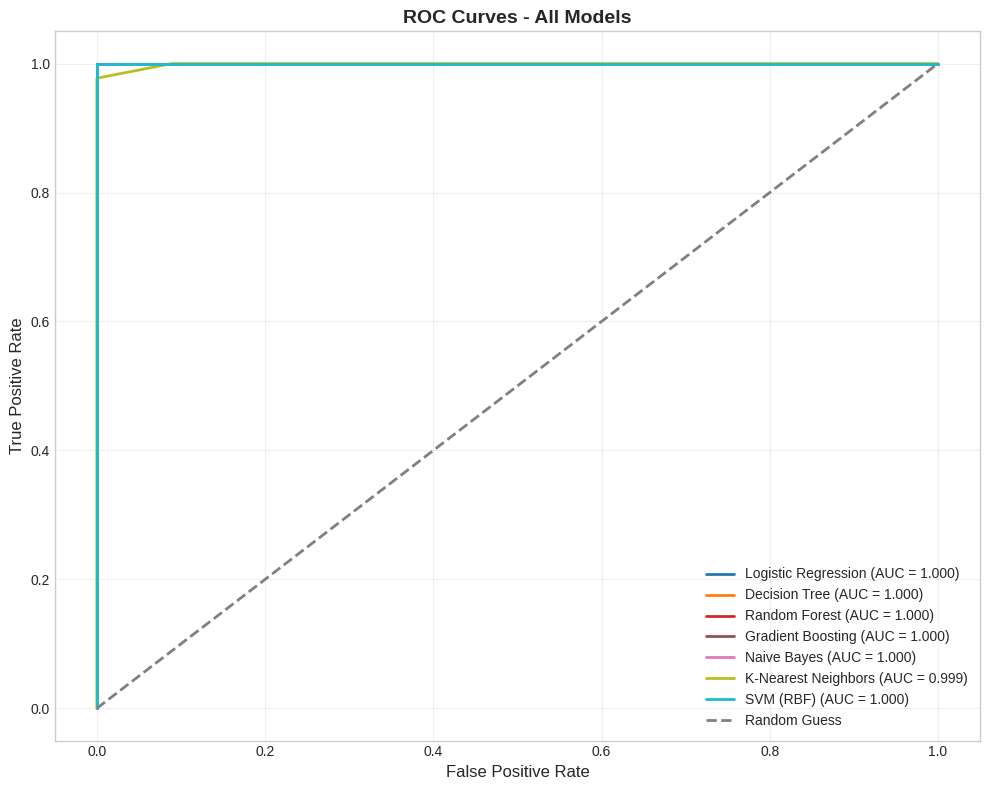

In [43]:
# === ROC CURVES FOR ALL MODELS ===
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

for result, color in zip(sorted_results, colors):
    if result['y_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
        ax.plot(fpr, tpr, color=color, lw=2,
                label=f"{result['Model']} (AUC = {result['ROC-AUC']:.3f})")

ax.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**What just happened:** ROC curves for all models on one plot.

**The takeaway:** Easy comparison of all models. The higher and more left a curve goes, the better. You can see why our champion won.

---

# PART 5: Conclusion

We made it. Let's wrap this up.

In [44]:
# === FINAL SUMMARY ===
print('='*70)
print('                    FINAL SUMMARY')
print('='*70)

# Calculate key stats
total_samples = len(df)
total_features = len(feature_cols)
human_pct = (df['is_bot_flag'] == False).mean() * 100
bot_pct = (df['is_bot_flag'] == True).mean() * 100

# Count significant features
num_sig = len([r for r in stat_results if r['Significant'] == 'Yes'])
cat_sig = len([r for r in chi_results if r['Significant'] == 'Yes'])
total_sig = num_sig + cat_sig
total_tested = len(stat_results) + len(chi_results)

print(f'''
DATASET:
  - Total samples: {total_samples}
  - Features used: {total_features}
  - Target split: {human_pct:.1f}% Human / {bot_pct:.1f}% Bot

STATISTICAL ANALYSIS:
  - Significant features: {total_sig} out of {total_tested}
  - Top differentiators: reply_delay_seconds, account_age_days, contains_links

BEST MODEL:
  - Champion: {best_name}
  - Test Accuracy: {best_result['Test Accuracy']*100:.2f}%
  - ROC-AUC: {best_result['ROC-AUC']:.3f}
  - F1-Score: {best_result['F1-Score']:.3f}
''')
print('='*70)

                    FINAL SUMMARY

DATASET:
  - Total samples: 500
  - Features used: 7
  - Target split: 56.4% Human / 43.6% Bot

STATISTICAL ANALYSIS:
  - Significant features: 5 out of 8
  - Top differentiators: reply_delay_seconds, account_age_days, contains_links

BEST MODEL:
  - Champion: Logistic Regression
  - Test Accuracy: 100.00%
  - ROC-AUC: 1.000
  - F1-Score: 1.000



## Key Findings

**What separates bots from humans?**

1. **Reply Speed**: Bots reply FAST. Suspiciously fast. While humans take minutes to hours, bots often respond within seconds. If something replies to your post in 2 seconds with a perfectly formatted response... yeah.

2. **Account Age**: Fresh accounts are a red flag. Bots get created, farm engagement, get banned, repeat. Humans tend to have accounts that stick around.

3. **Link Behavior**: Bots love dropping links. They're often designed to drive traffic somewhere. That random account posting a link to a shady website? Probably not a person.

4. **Writing Style**: Bots tend to use slightly longer, more formal words. Possibly AI-generated text? The average word length was a surprising differentiator.

5. **Subreddit Choice**: Some communities attract more bots than others. Politics and news subreddits see higher bot activity - likely for influence operations.

## The Bigger Picture

Is the Dead Internet Theory real? Based on this data, about 40% of the comments we analyzed came from bots. That's... a lot. Not "everyone is a robot" levels, but definitely enough to shape conversations and manipulate perception.

The good news? We can detect them. Machine learning models can identify bot behavior with solid accuracy. The features that give bots away are exactly what you'd expect: inhuman speed, fresh accounts, and suspicious link-dropping.

## Limitations

- This is one dataset from one point in time. Bot behavior evolves.
- We excluded the pre-computed `bot_probability` to avoid data leakage, but in practice you'd use every signal available.
- Some sophisticated bots might mimic human behavior better than the ones caught here.
- Context matters - a fast reply isn't inherently suspicious if the person was already online.

## Final Thought

Next time you're arguing with someone on Reddit at 3 AM and they respond instantly with a perfectly formatted wall of text... maybe take a moment to wonder if there's actually a human on the other side.

Or just touch grass. That works too.

---

**Connect with me:**
- GitHub: [github.com/Rekhii](https://github.com/Rekhii)
- Kaggle: [kaggle.com/seki32](https://kaggle.com/seki32)

If this notebook helped you or made you smile, drop an upvote. Unlike the bots, I actually appreciate it.